# Rotations of field objects

In this notebook we will investgate ways to rotate field objects in multiple differnt ways.

## Defining rotations
In order to rotate a vector, we can multiply the vector by a rotation matrix
\begin{equation}
    v_2 = R v_1
\end{equation}
where $v_1$ is the initial vetor, $v_2$ is the rotated vector, and $R$ is the rotation matrix.
The rotation martix can be calculated using a variety of methods.

![rotations1](Figures/coor_rotation.png)

### Basic rotations
For basic rotations, the rotation by an angle $\theta$ can be specified for rotations about each of the $x$, $y$, and $z$ axis.

The full rotation matrix for general rotations is given by
\begin{equation}
    R = R_z \left( \theta_z\right) R_y \left( \theta_y\right) R_x \left( \theta_x\right),
\end{equation}
where,
\begin{align}
    R_x \left( \theta_x\right) & = \begin{bmatrix}
                                    1 & 0 & 0 \\
                                    0 & \cos\theta_x & -\sin \theta_x \\
                                    0 & \sin\theta_x & \cos\theta_x
                                   \end{bmatrix} \\
    R_y \left( \theta_y\right) & = \begin{bmatrix}
                                    \cos\theta_y & 0 & \sin\theta_y \\
                                    0 & 1 & 0 \\
                                    -\sin\theta_y & 0 & \cos\theta_y
                                   \end{bmatrix}\\
    R_z \left( \theta_z\right) & = \begin{bmatrix}
                                    \cos\theta_z & -\sin\theta_z & 0 \\
                                    \sin\theta_z & \cos\theta_z & 0 \\
                                    0 & 0 & 1
                                   \end{bmatrix}
\end{align}

In [ ]:
import numpy as np

In [ ]:
def rot_x(theta_x):
    r""" Rotation about the $x$ axis.
    """
    return [[1, 0, 0],
            [0, np.cos(theta_x), -np.sin(theta_x)],
            [0, np.sin(theta_x), np.cos(theta_x)]]

def rot_y(theta_y):
    r""" Rotation about the $y$ axis.
    """
    return [[np.cos(theta_y), 0, np.sin(theta_y)],
            [0, 1, 0],
            [-np.sin(theta_y), 0, np.cos(theta_y)]]

def rot_z(theta_z):
    r""" Rotation about the $z$ axis.
    """
    return [[np.cos(theta_z), -np.sin(theta_z), 0],
            [np.sin(theta_z), np.cos(theta_z), 0],
            [0, 0, 1]]

def rot_tot(theta_x=0, theta_y=0, theta_z=0):
    r""" Full rotation matrix for basic roation method.
    """
    return np.matmul(rot_z(theta_z),np.matmul(rot_y(theta_y), rot_x(theta_x)))

def rot_vector_mat(v, r_matrix):
    r""" Rotate vector based on matrix.
    """
    return np.matmul(r_matrix, v)

In [ ]:
theta_x = 0
theta_y = 0
theta_z = np.pi/2
v1 = [1, 0, 0]
r_mat = rot_tot(theta_x, theta_y, theta_z)
v2 = rot_vector_mat(v1, r_mat)
v2

### Rotations about an axis
Another way to define a rotation is by an angle $\theta$ about an axis of a vector ${\bf u}$.
This leads to the rotatiom matrix

\begin{equation}
    R = \begin{bmatrix}
         u_x^2 + (u_y^2 + u_z^2) \cos\theta & u_x u_y (1-\cos\theta) - u_z \sin\theta & u_x u_z (1-\cos\theta) + u_y \sin\theta \\
         u_x u_y (1-\cos\theta) + u_z \sin\theta & u_y^2 + (u_x^2 + u_z^2) \cos\theta & u_y u_z (1-\cos\theta) - u_x \sin\theta \\
         u_x u_z (1-\cos\theta) - u_y \sin\theta & u_y u_z (1-\cos\theta) + u_x \sin\theta & u_z^2 + (u_x^2 + u_y^2) \cos\theta
        \end{bmatrix}
\end{equation}

![rotations3](Figures/rotation_about_v_2.png)

In [ ]:
def rot_mat_about_axis(theta, axis):
    r""" Full rotation matrix for roation about an axis method.
    """
    L = np.linalg.norm(axis)
    u = axis[0]/L
    v = axis[1]/L
    w = axis[2]/L
    
    line_1 = [u*u + (v*v + w*w) * np.cos(theta),
              u*v*(1-np.cos(theta)) - w*np.sin(theta),
              u*w*(1-np.cos(theta)) + v*np.sin(theta)]

    line_2 = [u*v*(1-np.cos(theta)) + w*np.sin(theta),
              v*v + (u*u + w*w) * np.cos(theta),
              v*w*(1-np.cos(theta)) - u*np.sin(theta)]
    
    line_3 = [u*w*(1-np.cos(theta)) - v*np.sin(theta),
              v*w*(1-np.cos(theta)) + u*np.sin(theta),
              w*w + (u*u + v*v) * np.cos(theta)]
    
    return np.array([line_1, line_2, line_3])

In [ ]:
theta = np.pi/2
axis = (0, 0, 1)
v1 = [1, 0, 0]
r_mat = rot_mat_about_axis(theta, axis)
v2 = rot_vector_mat(v1, r_mat)
v2

### Rotation to from one axis to another
The rotation matrix can also be calculated for rotating from one unit vector $a$ to another unit vector $b$ by using
\begin{equation}
    R = I + [v]_\times + \frac{[v]_\times^2}{1+c},
\end{equation}
where $I$ is the $3\times 3$ identity matrix, $v= a \times b$ and is the skew-symmetric cross-procuct of $v$
\begin{equation}
    [v]_\times = \begin{bmatrix}
                  0 & -v_3 & v_2 \\
                  v_3 & 0 & -v_1 \\
                  -v_2 & v_1 & 0 \\
                 \end{bmatrix},
\end{equation}
and $c= a \cdot b$.

![rotations4](Figures/rotation_to_v.png)

In [ ]:
def rot_mat_to_axis(to_vector,from_vector=[0,0,1]):
    r""" Full rotation matrix for roation from one vector to another method.
    """
    from_vector = from_vector/np.linalg.norm(from_vector)
    to_vector = to_vector/np.linalg.norm(to_vector)
    
    #if np.allclose(to_vector,from_vector) or np.allclose(to_vector,-from_vector):
    #    return np.identity(3)
    
    if np.allclose(to_vector,-from_vector):
        return ValueError()
    
    cross = np.cross(from_vector, to_vector)
    c = np.dot(from_vector, to_vector)
    
    v_x = np.array([[0, -cross[2], cross[1]],
                    [cross[2], 0, -cross[0]],
                    [-cross[1], cross[0],0]])
    v_x2 = np.matmul(v_x,v_x)
    
    
    r_mat = np.identity(3)
    r_mat += v_x
    r_mat += v_x2 / (1+c)
    
    return r_mat

In [ ]:
from_vector = (1, 0, 0)
to_vector = (0, 1, 0)
v1 = [1, 0, 0]
r_mat = rot_mat_to_axis(to_vector, from_vector)
v2 = rot_vector_mat(v1, r_mat)
v2

### Generation of a rotation matrix with differnt methods

In [ ]:
def rotation_matrix(method, **kwargs):
    r""" Calculate rotation matrix for differnt methods.
    """

    if method == 'basic':
        return rot_tot(**kwargs)
    elif method == 'about_axis':
        return rot_mat_about_axis(**kwargs)
    elif method == 'to_vector':
        return rot_mat_to_axis(**kwargs)
    else:
        msg = f'Method {method} is unknown.'
        raise ValueError(msg)


In [ ]:
r_mat = rotation_matrix_2('basic', theta_z=np.pi/2)
v2 = rot_vector_mat(v1, r_mat)
v2

## Rotations of field objects 
In order to rotate a field object, there are multiple steps that need to be computed such as the rotation of the vector field and the rotation of the mesh.

In [ ]:
import discretisedfield as df
from scipy.interpolate import RegularGridInterpolator

#### Calculating new region
The new region is calculated using a method with make sure the new region is the correct size without any wasted space. This adaptive sizing is demonstrated for 2D in the following figure
![region](Figures/new_region.png)

In [ ]:
def calculate_new_region(field, r_matrix):
    edges = np.array(field.mesh.region.edges)
    rot_edge_x = abs(rot_vector_mat([edges[0], 0, 0], r_matrix))
    rot_edge_y = abs(rot_vector_mat([0, edges[1], 0], r_matrix))
    rot_edge_z = abs(rot_vector_mat([0, 0, edges[2]], r_matrix))
    tot_edge_len = rot_edge_x + rot_edge_y + rot_edge_z
    p1_new = field.mesh.region.centre - tot_edge_len/2
    p2_new = field.mesh.region.centre + tot_edge_len/2
    return df.Region(p1=p1_new, p2=p2_new)

#### Calculating the new number of cells
If the number of desired cell is not stipulated. At the moment this is done by calculating the cell shape in the new mesh and  

In [ ]:
def calculate_new_n(field, new_region, r_matrix):
    d_arr_rot_x = abs(rot_vector_mat([field.mesh.dx, 0, 0], r_matrix))
    d_arr_rot_y = abs(rot_vector_mat([0, field.mesh.dy, 0], r_matrix))
    d_arr_rot_z = abs(rot_vector_mat([0, 0, field.mesh.dz], r_matrix))
    d_arr_rot = d_arr_rot_x + d_arr_rot_y + d_arr_rot_z
    new_n = np.ceil(np.divide(new_region.edges, d_arr_rot)).astype(int).tolist()
    return new_n

In [ ]:
def calculate_new_n_2(field, new_region, r_matrix):
    d_arr_rot_x = abs(rot_vector_mat([field.mesh.dx, 0, 0], r_matrix))
    d_arr_rot_y = abs(rot_vector_mat([0, field.mesh.dy, 0], r_matrix))
    d_arr_rot_z = abs(rot_vector_mat([0, 0, field.mesh.dz], r_matrix))
    d_arr_rot = d_arr_rot_x + d_arr_rot_y + d_arr_rot_z
    vol_new = np.prod(d_arr_rot)
    vol_old = field.mesh.dV
    adjust = (vol_old/vol_new)**(1/3)
    new_n = np.round(np.divide(new_region.edges, d_arr_rot*adjust)).astype(int).tolist()
    return new_n

#### Rotating the field
The vectors of the field are first rotated into the new reference frame. Interpolation functions are created from the original mesh and new field vectors. The new mesh is then mapped back onto the old mesh and the interpolation functions are used to determine the value of the rotated field on the rotated mesh.

In [ ]:
def rotate_field_components(field, r_matrix):
    pre_rot_field = np.concatenate([field.array[..., 0].flatten()[..., None],
                                    field.array[..., 1].flatten()[..., None],
                                    field.array[..., 2].flatten()[..., None]], axis=1)
    rot_field = []
    for v in pre_rot_field:
        rot_field.append(rot_vector_mat(v, r_matrix))
    return np.array(rot_field).reshape(field.mesh.n + (field.dim,))


def create_interpolation_funcs(field, rot_field):
    mesh_field = df.Field(mesh=field.mesh, dim=3, value=lambda x: x)
    x = mesh_field.array[:, 0, 0, 0] - field.mesh.region.centre[0] # To rotate about center od mesh
    y = mesh_field.array[0, :, 0, 1] - field.mesh.region.centre[1]
    z = mesh_field.array[0, 0, :, 2] - field.mesh.region.centre[2]
    mx = np.pad(rot_field[..., 0], pad_width=((1,1), (1,1), (1,1)), mode='edge') # Pad by 1 to deal with edge effects
    my = np.pad(rot_field[..., 1], pad_width=((1,1), (1,1), (1,1)), mode='edge')
    mz = np.pad(rot_field[..., 2], pad_width=((1,1), (1,1), (1,1)), mode='edge')
    
    tol = 1e-5
    x = np.array([x[0] - field.mesh.dx/2*(1+tol), *x, x[-1] + field.mesh.dx/2*(1+tol)]) # Add coordinate of boundary
    y = np.array([y[0] - field.mesh.dy/2*(1+tol), *y, y[-1] + field.mesh.dy/2*(1+tol)]) 
    z = np.array([z[0] - field.mesh.dz/2*(1+tol), *z, z[-1] + field.mesh.dz/2*(1+tol)])
    interp_func_mx = RegularGridInterpolator((x, y, z), mx, fill_value=0.0, bounds_error=False)
    interp_func_my = RegularGridInterpolator((x, y, z), my, fill_value=0.0, bounds_error=False)
    interp_func_mz = RegularGridInterpolator((x, y, z), mz, fill_value=0.0, bounds_error=False)
    
    return (interp_func_mx, interp_func_my, interp_func_mz)

def map_and_interpolate(new_mesh, r_matrix, interp_funcs):
    inv_r_matrix = np.linalg.inv(r_matrix) ## Inverse rotation matrix
    
    new_mesh_field = df.Field(mesh=new_mesh, dim=3, value=lambda x: x)
    new_mesh_pos = np.concatenate([new_mesh_field.array[..., 0].flatten()[..., None] - field.mesh.region.centre[0],
                                   new_mesh_field.array[..., 1].flatten()[..., None] - field.mesh.region.centre[1],
                                   new_mesh_field.array[..., 2].flatten()[..., None] - field.mesh.region.centre[2]], axis=1)

    ### Map new mesh onto the old mesh
    new_pos_old_mesh = []
    for mp in new_mesh_pos:
        new_pos_old_mesh.append(rot_vector_mat(mp, inv_r_matrix))
    new_pos_old_mesh = np.array(new_pos_old_mesh)

    ### Get values of field at new mesh locations
    interp_func_mx = interp_funcs[0]
    interp_func_my = interp_funcs[1]
    interp_func_mz = interp_funcs[2]
    new_mx = interp_func_mx(new_pos_old_mesh).reshape(new_mesh.n)
    new_my = interp_func_my(new_pos_old_mesh).reshape(new_mesh.n)
    new_mz = interp_func_mz(new_pos_old_mesh).reshape(new_mesh.n)
    return np.stack([new_mx,new_my,new_mz], axis=3)

In [ ]:
def rotate_field(field, method, rot_dic, n=None):
    ### Rotation matrix
    r_matrix = rotation_matrix(method, rot_dic = rot_dic)
    
    ### Calculate new region
    new_region = calculate_new_region(field, r_matrix)
    
    ### Calculate new number of cells
    if n is None:
        new_n = calculate_new_n_2(field, new_region, r_matrix)
    else:
        new_n = n
        
    ### Create new mesh
    new_mesh = df.Mesh(region=new_region, n=new_n)
    
    ### Rotate Field vectors
    rot_field = rotate_field_components(field, r_matrix)

    ### Create intepolation
    interp_funcs = create_interpolation_funcs(field, rot_field)
    
    ### Calculate field at new mesh positions
    new_m = map_and_interpolate(new_mesh, r_matrix, interp_funcs)

    ### Construct new field
    return df.Field(mesh=new_mesh, dim=3, value=new_m)

region = df.Region(p1=(0, 0, 0), p2=(11, 11, 11))
mesh = df.Mesh(region=region, cell=(1,1,1))
field = df.Field(mesh=mesh, dim=3, value=(1, 1, 1))
field.plane('z').mpl()

In [ ]:
region = df.Region(p1=(-5, -5, 0), p2=(5, 5, 1))
mesh = df.Mesh(region=region, n=(11,5,1))
def mag(pos):
    x, y, z = pos
    return [-y,x,1]

field = df.Field(mesh=mesh, dim=3, value=mag, norm=1)
field.plane('z').mpl()

In [ ]:
field.k3d.vector()

In [ ]:
#method = 'basic'
#rot_dic = {'theta_x' : np.pi/4}
method = 'to_vector'
rot_dic = {'to_vector' : (1,1,1), 'from_vector' : (0,0,1)}
new_field = rotate_field(field, method, rot_dic=rot_dic)

In [ ]:
method = 'to_vector'
rot_dic = {'from_vector' : (1,1,1), 'to_vector' : (0,0,1)}
new_field_2 = rotate_field(new_field, method, rot_dic=rot_dic)

In [ ]:
new_field_2.mesh

In [ ]:
new_field.mesh.dV

In [ ]:
new_field_2.plane(z=1.5).y.mpl()

In [ ]:
new_field_2.norm.k3d.nonzero()

In [ ]:
new_field.integral('z').z.mpl()

In [ ]:
new_field_2.k3d.vector()

In [ ]:
%%timeit
rotate_field(field, method, rot_dic=rot_dic, n=(61,61,61))

In [1]:
import discretisedfield as df
import numpy as np

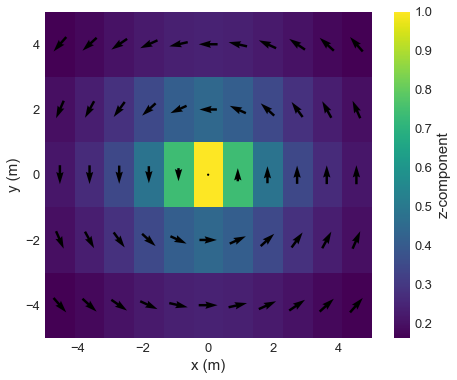

In [2]:
region = df.Region(p1=(-5, -5, 0), p2=(5, 5, 1))
mesh = df.Mesh(region=region, n=(11,5,1))
def mag(pos):
    x, y, z = pos
    return [-y,x,1]

field = df.Field(mesh=mesh, dim=3, value=mag, norm=1)
field.plane('z').mpl()

In [4]:
rfield = df.RotatedField(field, method='basic', theta_z=np.pi/2)

In [10]:
rfield._rotation_matrix

array([[ 6.123234e-17, -1.000000e+00,  0.000000e+00],
       [ 1.000000e+00,  6.123234e-17,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00]])